# Predicting performance direction of Premier League Footballers using 'Fantasy Football' data and Machine learning

Using a LTSM neural network trained with data collected from 3 seasons of Premier League Football games, a predictive model of player performance was made. By 'direction of performance,' it is simply meant whether a player performed better or worse in the next matched player relative to the previous week, i.e. a simple binary choice. Thus, a categorical model is used here.

Below the construction of this model is outlined.

### Importing and normalizing data
The data being used to train the model has been collected from the Official Premier League online game 'Fantasy Premier League." This online game tracks multiple performance attributes for the sport, such as number of shots or number of fouls committed by each player every week, and based on these variables gives each player a score every week. The score that each player gets depends primarily on the number of bonus points ('bps') they recieve, which is determined by set rules- for example 4 bps if they score a goal, 2 bps for playing 90 minutes (the length of a premier league football match) or -2 points if the player receives a red card. These rules are not of direct consequence for the analysis but the full list is found here- https://fantasy.premierleague.com/help/rules.

The number of bps awarded to a given player additionally depends on how well that player performs relative to other players in the same match for that week. Thus, bps, and total points awarded per week, are sufficiently random variables that prediction of them is a problem well suited for machine learning, given the large number of variables which may impact these dependent variables.

The first step for the analysis is to import the data, which is seperated into data for each season, and within each season separated into individual .csv files for each player. Each file then has various attribute values recorded for each week (of which there are 38 weeks). We begin by importing the required modules and defining the classification function, which will be used for defining the performance direction:

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

Next, the csv files need to be processed. Using the file 'raw_data/2016-17/players/Sergio_Agüero/gw.csv' as an example to show the format of these files, we have:

In [2]:
dat = pd.read_csv("raw_data/2016-17/players/Sergio_Agüero/gw.csv")
dat.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards'],
      dtype='object')

To determine which variables potentially correlate with the target variables 'bps' and 'total_points,' the variable which the model will predict, use the corr() function:

In [3]:
dat["future_points"] = dat['bps'].shift(+1)
dat.corr()[["bps","future_points"]]

,bps,future_points
assists,0.500451,-0.194994
attempted_passes,0.586816,0.170655
big_chances_created,0.333012,-0.004426
big_chances_missed,0.048586,0.197941
bonus,0.909670,-0.015912
bps,1.000000,-0.013018
clean_sheets,0.282780,0.242436
clearances_blocks_interceptions,0.188060,0.089263
completed_passes,0.614451,0.130888
creativity,0.728404,0.156208


Since the data set being used is large, and given that players in different positions will likely have different dependancies on different variables (for example, Sergio_Agüero is a forward so his bps is potentially more dependent on the variable 'creativity' and less dependent on 'clean_sheets' than a defender would be) we will initially use only the most general variables that have the highest correlation with bps:

In [4]:
variables = ["assists", "attempted_passes", "big_chances_missed", "clean_sheets", "completed_passes",
             "creativity", "dribbles", "goals_conceded", "goals_scored", "ict_index", "key_passes",
            "transfers_in", "transfers_out", "value", "bps", "total_points", "future_points", "round", "minutes",
            "selected", "red_cards", "threat", "transfers_balance"]
dat = dat[variables]
dat.head()

,assists,attempted_passes,big_chances_missed,clean_sheets,completed_passes,creativity,dribbles,goals_conceded,goals_scored,ict_index,...,value,bps,total_points,future_points,round,minutes,selected,red_cards,threat,transfers_balance
0,0,33,0,0,26,29.6,1,1,1,14.3,...,130,33,9,NaN,1,90,1380299,0,81.0,0
1,0,21,0,0,17,13.3,2,1,2,16.7,...,130,57,13,33.0,2,82,1634994,0,77.0,63510
2,0,27,0,0,21,17.5,4,1,0,5.2,...,131,6,2,57.0,3,87,1943851,0,36.0,204625
3,0,0,0,0,0,0.0,0,0,0,0.0,...,130,0,0,6.0,4,0,1015145,0,0.0,-952929
4,0,0,0,0,0,0.0,0,0,0,0.0,...,130,0,0,0.0,5,0,864663,0,0.0,-156373


A general function is now required to loop through all the files and select the required columns as shown above. Whilst most files are 38 data entries long, there are some anomolies in length which need to be accounted for, which is done below. 

In particular, some of the .csv files many not be of length 38 because the player they correspond too didn't play for a club in the premier league for the whole season. In this case, the rounds are re-labelled, to provide some consistency in how the data is formatted, which is necessary as later the rounds will be used as an index. N.b. the fact that the round indices may not be correctly labelled (as some players may play for the first half of the season and others the second etc, and this detail is lost in the above function's relabelling) is not relevant, as the network will be trained to analyse short-term patterns, and thus the time of season is not a factor.

In [5]:
def Select_Columns():
    new_directory = f"filtered_data_{datetime.date.today()}"
    os.mkdir(f"{new_directory}")
    rounds_array = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                    21, 22, 23, 24,25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
    
    # Fix incorrect indexing in data:
    years = [[16, 17], [17, 18], [18, 19]]
    for year in years:
        player_list = pd.read_csv(f'raw_data/20{year[0]}-{year[1]}/player_idlist.csv')
        for i in range(len(player_list)):
            try:
                player = pd.read_csv(f'raw_data/20{year[0]}-{year[1]}/players/{player_list.iloc[i][0]}_{player_list.iloc[i][1]}/gw.csv')
                if len(player["round"]) == 38:
                    if player["round"].iloc[-1] != 38:
                        player["round"].iloc[-1] = 38
                difference_length = 38 - len(player["round"])
                if len(player["round"]) == 38:
                    player["round"] = rounds_array
                else:
                    player["round"] = rounds_array[difference_length:]
                player["future_points"] = player['bps'].shift(+1)
                player = player[variables]
                with open(f"{new_directory}/{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{year[0]}.csv", 'w') as file:
                    player.to_csv(file, header=True, mode='w',index=False)
                        
            except:
                player = pd.read_csv(f'raw_data/20{year[0]}-{year[1]}/players/{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{player_list.iloc[i][2]}/gw.csv')
                if len(player["round"]) == 38:
                    if player["round"].iloc[-1] != 38:
                        player["round"].iloc[-1] = 38
                difference_length = 38 - len(player["round"])
                if len(player["round"]) == 38:
                    player["round"] = rounds_array
                else:
                    player["round"] = rounds_array[difference_length:]
                player["future_points"] = player['bps'].shift(+1)
                player = player[variables]
                with open(f"{new_directory}/{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{year[0]}.csv", 'w') as file:
                    player.to_csv(file, header=True, mode='w',index=False)
                        
    return new_directory

working_dir = Select_Columns()

Next, normalize and then structure the data in preparation for passing onto the LTSM:

In [6]:
def Normalise(passed_directory):
    """ Add new column, 'Performance_direction,' to label whether a player performed better
    or worse next week relative to the current week:"""
    
    for filename in os.listdir(passed_directory):
        if filename.endswith(".csv"):
            df = pd.read_csv(f"{passed_directory}/{filename}")
            df["performance_direction"] = list(map(classify, df["future_points"], df["total_points"]))
            with open(f"{passed_directory}/{filename}", 'w') as file:
                df.to_csv(file, header=True, mode='w',index=False)
    
    """ Create a new dict to hold the maxiumum values for each variable, which can then
    be used to normalise the data. The column 'round' is dropped as it is not a variable,
    and 'performance_direction' is added."""
    
    max_values= np.zeros(19)
    variables.remove("round")
    variables.append("performance_direction")
    variables_max_values = dict(zip(variables, max_values))
    """ loop through all files to determine max values"""
    for filename in os.listdir(passed_directory):
        if filename.endswith(".csv"):
            df = pd.read_csv(f"{passed_directory}/{filename}")
            if len(df.index) > 1:
                for var, value in variables_max_values.items():
                    if df.at[df[var].idxmax(axis=1), var] > value:
                        variables_max_values[var] = df.at[df[var].idxmax(axis=1), var]
            else:
                pass
            
    """ loop through a second time to normalise"""
    os.mkdir(f"Normalised_{passed_directory}")
    for filename in os.listdir(passed_directory):
        if filename.endswith(".csv"):
            df = pd.read_csv(f"{passed_directory}/{filename}")
            for var, value in variables_max_values.items():
                df[var]= df[var].div(value)
    
        """ save file for later if there are more than 30 non-zero entries"""
        if df["minutes"][df["minutes"] > 0].count() > 30:
            with open(f"Normalised_{passed_directory}/{filename}", 'w') as file:
                df.to_csv(file, header=True, mode='w', index=False)
    new_directory = f"Normalised_{passed_directory}"
    return variables_max_values, new_directory
    
normlisation_factors, working_dir = Normalise(working_dir)

Now that the data is normalised it must be re-grouped in preparation for the LTSM. The length in the function below refers to the number of periods of data that will be feed into the model at once, i.e. Length = 3 corresponds to 3 weeks of match data. In order for temporal patterns in the data to be abstracted, it is necessary for the order to be retained in each data set, which is what the function deque allows for below.

In [10]:
def Sequence_data(passed_directory, length):
    j=0
    SEQ_LEN = length
    sequential_data = []  # this is a list that will CONTAIN the sequences
    for filename in os.listdir(f"{passed_directory}"):
        if filename.endswith(".csv"):
            df = pd.read_csv(f"{passed_directory}/{filename}", index_col="round")
            input_df = df[["transfers_in", "transfers_out",'bps', 'ict_index', 'minutes', 'performance_direction']]  # performance predictior network from 'bps', 'ict_index', 'minutes'
            prev_days = deque(maxlen=SEQ_LEN)  
            for i in input_df.values: 
                prev_days.append([n for n in i[:-1]])  
                if len(prev_days) == SEQ_LEN:  
                    sequential_data.append([np.array(prev_days), i[-1]])  
    random.shuffle(sequential_data)
    #print(np.shape(sequential_data))
    #normal_data = min_max_scaler.fit_transform(np.array(sequential_data))
    return sequential_data


Length = 3
one= Sequence_data(working_dir, Length)


In [11]:
x = []
Y = []
for features, result in one:
    x.append(features)
    Y.append(result)
x = np.array(x, dtype="float32")

In [12]:
import tensorflow as tf
import sklearn
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from collections import deque
import random

In [13]:
def Network(IN, OUT, TIME_PERIOD, EPOCHS, BATCH_SIZE, LTSM_SHAPE):
 
    length = len(OUT)
    train_x = IN[:int(0.9 * length)]
    validation_x = IN[int(0.9 * length):]
    train_y = OUT[:int(0.9 * length)]
    validation_y = OUT[int(0.9 * length):]

    # Define Network & callback:
    NAME = f"pb_{TIME_PERIOD}_{EPOCHS}_{BATCH_SIZE}_{LTSM_SHAPE}_{time.time()}"
    ternsorboard = TensorBoard(log_dir=f"logs/{NAME}")

    model = Sequential()
    model.add(LSTM(LTSM_SHAPE, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())  # normalizes activation outputs, same reason you want to normalize your input data.

    model.add(LSTM(LTSM_SHAPE, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(LSTM(LTSM_SHAPE))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    train_y = np.asarray(train_y)
    validation_y = np.asarray(validation_y)
    history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(validation_x, validation_y), callbacks=[ternsorboard])
    print('\nhistory dict:', history.history)

    # Score model
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # Save model
    model.save(f"models/{NAME}")

EPOCHS, BATCH_SIZE, LTSM_SHAPE = 15, 32, 128

Network(x, Y, Length, EPOCHS, BATCH_SIZE, LTSM_SHAPE)

Train on 12779 samples, validate on 1420 samples
Epoch 1/15
12779/12779 [==============================] - 8s 648us/sample - loss: 0.3909 - accuracy: 0.8349 - val_loss: 0.3780 - val_accuracy: 0.8486
Epoch 2/15
12779/12779 [==============================] - 4s 329us/sample - loss: 0.2407 - accuracy: 0.9041 - val_loss: 0.1300 - val_accuracy: 0.9408
Epoch 3/15
12779/12779 [==============================] - 4s 287us/sample - loss: 0.1518 - accuracy: 0.9357 - val_loss: 0.1966 - val_accuracy: 0.9056
Epoch 4/15
12779/12779 [==============================] - 4s 297us/sample - loss: 0.1243 - accuracy: 0.9465 - val_loss: 0.1159 - val_accuracy: 0.9507
Epoch 5/15
12779/12779 [==============================] - 4s 294us/sample - loss: 0.1114 - accuracy: 0.9545 - val_loss: 0.0867 - val_accuracy: 0.9634
Epoch 6/15
12779/12779 [==============================] - 4s 295us/sample - loss: 0.1086 - accuracy: 0.9582 - val_loss: 0.1023 - val_accuracy: 0.9549
Epoch 7/15
12779/12779 [===========================

A classifier program with such high accuracy suggests that the data can potentially be used to construct a more useful model, and we will attempt to produce a regression program to predict the actual points that a player will get in future.

Begin similarly to before by making a function to produce appropriate groups of data, ordered temporaly and containing the paramaters which will be used to make the prediction:

In [14]:
%load_ext tensorboard

In [15]:
!rm -rf ./logs/ 

In [16]:
def Sequence_data_i(passed_directory, length):
    j=0
    SEQ_LEN = length
    sequential_data = []  # this is a list that will CONTAIN the sequences
    for filename in os.listdir(f"{passed_directory}"):
        if filename.endswith(".csv"):
            df = pd.read_csv(f"{passed_directory}/{filename}", index_col="round")
            input_df = df[['value',
                           'transfers_in', 
                           'transfers_out', 
                           'bps', 
                           'ict_index', 
                           'minutes', 
                           'selected', 
                           'goals_scored', 
                           'goals_conceded', 
                           'red_cards', 
                           'creativity', 
                           'threat', 
                           'transfers_balance',
                          'future_points']]
            prev_days = deque(maxlen=SEQ_LEN)  
            for i in input_df.values: 
                prev_days.append([n for n in i[:-1]])  
                if len(prev_days) == SEQ_LEN:  
                    sequential_data.append([np.array(prev_days), i[-1]])  
    random.shuffle(sequential_data)
    #print(np.shape(sequential_data))
    #normal_data = min_max_scaler.fit_transform(np.array(sequential_data))
    return sequential_data

Length = 6
x1 = []
Y2 = []
two= Sequence_data_i(working_dir, Length)
for features, result in two:
    x1.append(features)
    Y2.append(result)

x1 = np.asarray(x1)
Y2 = np.asarray(Y2)

The x1 array contains the input paramaters and Y2 the corresponding output paramaters. Now the network can be trained using this data:

In [17]:
import tensorflow as tf
import datetime
from tensorflow.keras.optimizers import SGD
DropOut = 0.25
def Network_ii(IN, OUT, TIME_PERIOD, EPOCHS, BATCH_SIZE, LTSM_SHAPE):
 
    length = len(OUT)
    train_x = IN[:int(0.9 * length)]
    validation_x = IN[int(0.9 * length):]
    train_y = OUT[:int(0.9 * length)]
    validation_y = OUT[int(0.9 * length):]

    # Define Network & callback:
    train_x = train_x.reshape(train_x.shape[0],Length, 13)
    validation_x = validation_x.reshape(validation_x.shape[0],Length, 13)
    

    model = Sequential()
    model.add(LSTM(units=60, return_sequences= True, input_shape=(train_x.shape[1],13)))
    model.add(LSTM(LTSM_SHAPE, return_sequences=True))
    model.add(Dropout(DropOut))
    model.add(BatchNormalization())
    model.add(LSTM(LTSM_SHAPE, return_sequences=True))
    model.add(Dropout(DropOut))
    model.add(BatchNormalization())
    model.add(LSTM(LTSM_SHAPE, return_sequences=True))
    model.add(Dropout(DropOut))
    model.add(BatchNormalization())
    model.add(LSTM(units=30))
#     model.add(SimpleRNN(units=30))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f"{Length}_" + f"{DropOut}" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    train_y = np.asarray(train_y)
    validation_y = np.asarray(validation_y)
    history = model.fit(train_x,
                        train_y, 
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(validation_x, validation_y),
                        callbacks = [tensorboard_callback]
                       )
    print('\nhistory dict:', history.history)

    # Score model
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Test loss:', score)
    # Save model
    model.save(f"models/new_model")

EPOCHS, BATCH_SIZE, LTSM_SHAPE = 15, 32, 128

Network_ii(x1, Y2, Length, EPOCHS, BATCH_SIZE, LTSM_SHAPE)

Train on 11712 samples, validate on 1302 samples
Epoch 1/15
11712/11712 [==============================] - 12s 1ms/sample - loss: 0.0176 - val_loss: 0.0098
Epoch 2/15
11712/11712 [==============================] - 6s 477us/sample - loss: 0.0097 - val_loss: 0.0089
Epoch 3/15
11712/11712 [==============================] - 6s 475us/sample - loss: 0.0090 - val_loss: 0.0083
Epoch 4/15
11712/11712 [==============================] - 6s 492us/sample - loss: 0.0087 - val_loss: 0.0083
Epoch 5/15
11712/11712 [==============================] - 6s 489us/sample - loss: 0.0085 - val_loss: 0.0084
Epoch 6/15
11712/11712 [==============================] - 6s 478us/sample - loss: 0.0086 - val_loss: 0.0086
Epoch 7/15
11712/11712 [==============================] - 6s 474us/sample - loss: 0.0085 - val_loss: 0.0085
Epoch 8/15
11712/11712 [==============================] - 5s 456us/sample - loss: 0.0084 - val_loss: 0.0083
Epoch 9/15
11712/11712 [==============================] - 5s 453us/sample - loss: 0.0084

In [18]:
ResultDist = pd.DataFrame(columns =['Predicted', 'Actual', 'Error'])

In [24]:
player_list = pd.read_csv(f'raw_data/2019-20/player_idlist.csv')
time_period = Length
pred_week = 11
paramaters =['value',
            'transfers_in', 
             'transfers_out', 
             'bps', 
             'ict_index', 
             'minutes', 
             'selected', 
             'goals_scored', 
             'goals_conceded', 
             'red_cards', 
             'creativity', 
             'threat', 
             'transfers_balance']
actual_performance = ['future_points']
# print("loading")
mod = tf.keras.models.load_model("models/new_model")
# print("loaded")
facts = normlisation_factors
errs=[]
totalerror=0
TOT =0
TOTAV = 0
for i in range(len(player_list)):
    player = pd.read_csv(f'raw_data/2019-20/players/{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{player_list.iloc[i][2]}/gw.csv', index_col='round')
    
    try:
        if player["bps"].iloc[11] > 0:
#             print(f"{player_list.iloc[i][0]}_{player_list.iloc[i][1]}:")
            for var, value in facts.items():
                try:
                    player[var]= player[var].div(value)
                except:
                    KeyError: 'attempted_passes'
                    pass
            try:
                player_in = player[paramaters].iloc[pred_week - time_period:pred_week]
                IN = np.array(player_in.values)
                IN_reshaped = IN.reshape(1,Length, 13)
                prediction = mod.predict(IN_reshaped)
#                 print("actual:", facts["bps"]*player["bps"].iloc[11])
#                 print("predicted:", facts["bps"]*prediction[0][0])
                totalerror += ((facts["bps"]*player["bps"].iloc[11]-facts["bps"]*prediction[0][0])**2)**0.5
                TOT +=1
                TOTAV += facts["bps"]*player["bps"].iloc[11]
                dif = facts["bps"]*(prediction[0][0] - player["bps"].iloc[11])
                ResultDist = ResultDist.append({'Predicted':facts["bps"]*prediction[0][0],
                                                'Actual':facts["bps"]*player["bps"].iloc[11],
                                                'Error': dif}, ignore_index=True)
            except (ValueError, IndexError) as e:
                print(e)
                errs.append(f"{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{player_list.iloc[i][2]}")
    
    except (ValueError, IndexError) as e:
        errs.append(f"{player_list.iloc[i][0]}_{player_list.iloc[i][1]}_{player_list.iloc[i][2]}")

The mean root squared error for this model is:

In [20]:
from scipy.stats import norm
import matplotlib.pyplot as plt

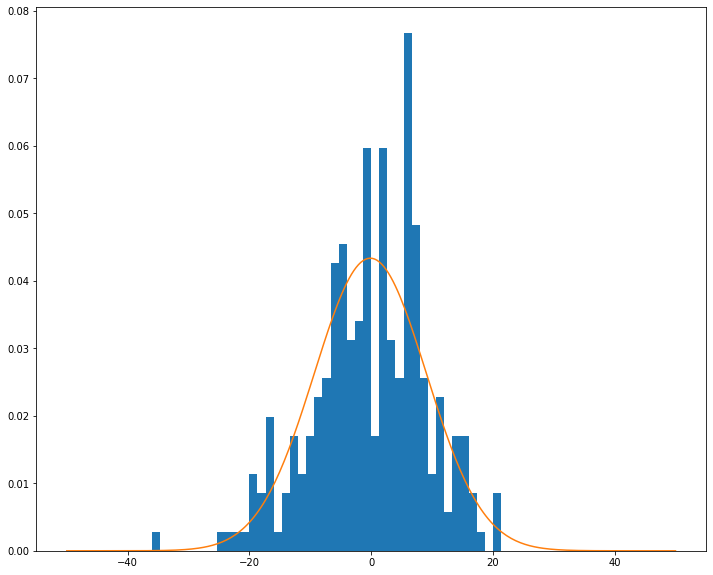

Means = -0.1308070984527917, Standard deviation = 9.20214458237294
95% of predictions within 18.40428916474588 of the mean.


In [21]:
data = ResultDist['Error'].values
plt.figure(figsize=(12,10))
plt.hist(data, bins=60, range=(-40,40), density=True)
from scipy import stats  
# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(data))

# lets try the normal distribution first
m, s = stats.norm.fit(data) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
plt.show()
print(f"Means = {m}, Standard deviation = {s}")
print(f"95% of predictions within {2*s} of the mean.")

The average number of point for a player in the data set is:

In [22]:
m

-0.1308070984527917

Thus the average error of the regression model is:

In [23]:
s

9.20214458237294

As the predictions above show, the model gives reasonably good predictions. Given the range of points that a player can achieve, although there is a significant error for some players, this is still useful metric, as the model tends to predict high scores for players who did score highly and vice versa. Due to the random nature of sport it is not surpising that there are a number of outliers however. Further invesigation into the nature of these outliers ( such as measuring the statistics of the error, eg, modelling it to a gaussian distribution)
would be useful in determining the exact nature of this model- it perhaps gives a good baseline prediction of players' performance, but does not allow for the random intricacies of the sport.

In [140]:
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.